In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from typing import Tuple, List, Dict, Any

In [4]:
class EnhancedNesterovAcceleratedGradient:    
    def __init__(self, learning_rate: float = 0.01, momentum: float = 0.9, 
                 max_iterations: int = 2000, tolerance: float = 1e-5, track_metrics: bool = True):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.track_metrics = track_metrics
        
        # Tracking metrics for empirical analysis
        self.cost_history = []
        self.gradient_norms = []
        self.weight_history = []
        self.velocity_history = []
        self.lookahead_history = []  # Track look-ahead positions
        self.convergence_info = {}
        
    def sigmoid(self, z: np.ndarray) -> np.ndarray:
        """Stable sigmoid function"""
        return np.where(z >= 0, 
                       1 / (1 + np.exp(-z)),
                       np.exp(z) / (1 + np.exp(z)))
    
    def compute_cost_and_gradients(self, X: np.ndarray, y: np.ndarray, 
                                  weights: np.ndarray, problem_type: str) -> Tuple[float, np.ndarray]:
        """
        Compute cost and gradients for different problem types
        
        Args:
            X: Feature matrix (m x n)
            y: Target values (m,)
            weights: Current weights (n,) - this will be the look-ahead position for NAG
            problem_type: 'regression', 'classification', 'non_convex'
        
        Returns:
            cost: Current cost value
            gradients: Gradient vector at the given weights position
        """
        m = X.shape[0]
        
        if problem_type == 'regression':
            # Linear regression (convex)
            predictions = X @ weights
            cost = (1 / (2 * m)) * np.sum((predictions - y) ** 2)
            gradients = (1 / m) * X.T @ (predictions - y)
            
        elif problem_type == 'classification':
            # Logistic regression (convex)
            z = X @ weights
            predictions = self.sigmoid(z)
            # Add small epsilon to prevent log(0)
            epsilon = 1e-15
            predictions = np.clip(predictions, epsilon, 1 - epsilon)
            
            cost = -(1 / m) * np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
            gradients = (1 / m) * X.T @ (predictions - y)
            
        elif problem_type == 'non_convex':
            # Non-convex function: Rosenbrock-like function
            cost = 0
            gradients = np.zeros_like(weights)
            
            for i in range(len(weights) - 1):
                cost += (weights[i+1] - weights[i]**2)**2 + 0.01 * (1 - weights[i])**2
                
                # Gradients for non-convex function
                gradients[i] += -4 * weights[i] * (weights[i+1] - weights[i]**2) - 0.02 * (1 - weights[i])
                gradients[i+1] += 2 * (weights[i+1] - weights[i]**2)
        
        return cost, gradients
    
    def add_gradient_noise(self, gradients: np.ndarray, noise_level: float = 0.01) -> np.ndarray:
        """Add noise to gradients for robustness analysis"""
        if noise_level > 0:
            noise = np.random.normal(0, noise_level, gradients.shape)
            return gradients + noise
        return gradients
    
    def fit(self, X: np.ndarray, y: np.ndarray, problem_type: str = 'classification', 
            noise_level: float = 0.0) -> Dict[str, Any]:
        """
        Fit the model using Nesterov Accelerated Gradient descent
        
        The key difference from momentum GD:
        - Standard momentum: v_t = γv_{t-1} + η∇f(w_t), w_{t+1} = w_t - v_t
        - NAG: v_t = γv_{t-1} + η∇f(w_t - γv_{t-1}), w_{t+1} = w_t - v_t
        
        Args:
            X: Feature matrix
            y: Target values
            problem_type: 'regression', 'classification', 'non_convex'
            noise_level: Amount of noise to add to gradients
            
        Returns:
            Dictionary with training results and analysis
        """
        # Initialize weights and momentum
        n_features = X.shape[1]
        weights = np.random.normal(0, 0.1, n_features)
        velocity = np.zeros_like(weights)  # Initialize momentum velocity
        
        # Reset tracking
        self.cost_history = []
        self.gradient_norms = []
        self.weight_history = []
        self.velocity_history = []
        self.lookahead_history = []
        
        prev_cost = float('inf')
        
        for iteration in range(self.max_iterations):
            # NESTEROV KEY STEP: Compute gradients at look-ahead position
            # Look-ahead position: w_t - γv_{t-1}
            lookahead_weights = weights - self.momentum * velocity
            
            # Compute cost and gradients at look-ahead position
            cost, gradients = self.compute_cost_and_gradients(X, y, lookahead_weights, problem_type)
            
            # Add noise if specified (for gradient noise analysis)
            if noise_level > 0:
                gradients = self.add_gradient_noise(gradients, noise_level)
            
            # Nesterov momentum update
            velocity = self.momentum * velocity + self.learning_rate * gradients
            weights = weights - velocity
            
            # Track metrics for empirical analysis
            if self.track_metrics:
                self.cost_history.append(cost)
                self.gradient_norms.append(np.linalg.norm(gradients))
                self.weight_history.append(weights.copy())
                self.velocity_history.append(velocity.copy())
                self.lookahead_history.append(lookahead_weights.copy())
            
            # Check for convergence (multiple criteria)
            cost_change = abs(prev_cost - cost)
            gradient_norm = np.linalg.norm(gradients)
            velocity_norm = np.linalg.norm(velocity)
            
            # Problem-specific convergence criteria
            if problem_type == 'classification':
                converged = (cost_change < max(self.tolerance * 10, 1e-5) or 
                           gradient_norm < max(self.tolerance * 100, 1e-4) or
                           velocity_norm < 1e-5)
            elif problem_type == 'regression':
                converged = (cost_change < self.tolerance or 
                           gradient_norm < self.tolerance * 10 or
                           velocity_norm < 1e-6)
            else:  # non_convex
                converged = (cost_change < self.tolerance * 5 or 
                           gradient_norm < self.tolerance * 50)
            
            if converged:
                self.convergence_info = {
                    'converged': True,
                    'iterations': iteration + 1,
                    'final_cost': cost,
                    'gradient_norm': gradient_norm,
                    'cost_change': cost_change,
                    'velocity_norm': velocity_norm
                }
                break
                
            prev_cost = cost
        else:
            self.convergence_info = {
                'converged': False,
                'iterations': self.max_iterations,
                'final_cost': cost,
                'gradient_norm': np.linalg.norm(gradients),
                'cost_change': abs(prev_cost - cost),
                'velocity_norm': np.linalg.norm(velocity)
            }
        
        self.final_weights = weights
        self.final_velocity = velocity
        return self.convergence_info
    
    def predict(self, X: np.ndarray, problem_type: str = 'classification') -> np.ndarray:
        """Make predictions using trained weights"""
        if not hasattr(self, 'final_weights'):
            raise ValueError("Model must be fitted before making predictions")
            
        if problem_type == 'regression':
            return X @ self.final_weights
        elif problem_type == 'classification':
            z = X @ self.final_weights
            return self.sigmoid(z)
        else:
            return X @ self.final_weights
    
    def analyze_momentum_values(self, X: np.ndarray, y: np.ndarray, 
                               momentum_values: List[float], problem_type: str = 'classification') -> Dict:
        """Empirical analysis of different momentum values for NAG"""
        results = {}
        
        for momentum in momentum_values:
            print(f"Testing NAG momentum: {momentum}")
            
            # Create new instance with specific momentum
            nag = EnhancedNesterovAcceleratedGradient(
                learning_rate=0.01, momentum=momentum, max_iterations=2000, track_metrics=True
            )
            convergence_info = nag.fit(X, y, problem_type)
            
            results[momentum] = {
                'convergence_info': convergence_info,
                'cost_history': nag.cost_history.copy(),
                'gradient_norms': nag.gradient_norms.copy(),
                'velocity_history': nag.velocity_history.copy(),
                'lookahead_history': nag.lookahead_history.copy(),
                'final_weights': nag.final_weights.copy()
            }
        
        return results
    
    def analyze_learning_rates(self, X: np.ndarray, y: np.ndarray, 
                              learning_rates: List[float], problem_type: str = 'classification') -> Dict:
        """Empirical analysis of different learning rates with NAG"""
        results = {}
        
        for lr in learning_rates:
            print(f"Testing NAG learning rate: {lr}")
            
            # Create new instance with specific learning rate
            nag = EnhancedNesterovAcceleratedGradient(
                learning_rate=lr, momentum=0.9, max_iterations=2000, track_metrics=True
            )
            convergence_info = nag.fit(X, y, problem_type)
            
            results[lr] = {
                'convergence_info': convergence_info,
                'cost_history': nag.cost_history.copy(),
                'gradient_norms': nag.gradient_norms.copy(),
                'velocity_history': nag.velocity_history.copy(),
                'lookahead_history': nag.lookahead_history.copy(),
                'final_weights': nag.final_weights.copy()
            }
        
        return results
    
    def analyze_gradient_noise(self, X: np.ndarray, y: np.ndarray, 
                              noise_levels: List[float], problem_type: str = 'classification') -> Dict:
        """Empirical analysis of gradient noise effects with NAG"""
        results = {}
        
        for noise in noise_levels:
            print(f"Testing NAG noise level: {noise}")
            
            nag = EnhancedNesterovAcceleratedGradient(
                learning_rate=0.01, momentum=0.9, max_iterations=2000, track_metrics=True
            )
            convergence_info = nag.fit(X, y, problem_type, noise_level=noise)
            
            results[noise] = {
                'convergence_info': convergence_info,
                'cost_history': nag.cost_history.copy(),
                'gradient_norms': nag.gradient_norms.copy(),
                'velocity_history': nag.velocity_history.copy(),
                'lookahead_history': nag.lookahead_history.copy()
            }
        
        return results
    
    def plot_convergence_analysis(self, results: Dict, analysis_type: str = 'momentum'):
        """Plot convergence behavior for empirical analysis"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle(f'Nesterov Accelerated GD Convergence Analysis - {analysis_type.replace("_", " ").title()}', 
                     fontsize=16)
        
        # Plot 1: Cost vs Iterations
        ax1 = axes[0, 0]
        for param, data in results.items():
            iterations = range(len(data['cost_history']))
            ax1.plot(iterations, data['cost_history'], label=f'{analysis_type}: {param}', linewidth=2)
        ax1.set_xlabel('Iterations')
        ax1.set_ylabel('Cost')
        ax1.set_title('Cost Function Convergence')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_yscale('log')
        
        # Plot 2: Gradient Norms
        ax2 = axes[0, 1]
        for param, data in results.items():
            iterations = range(len(data['gradient_norms']))
            ax2.plot(iterations, data['gradient_norms'], label=f'{analysis_type}: {param}', linewidth=2)
        ax2.set_xlabel('Iterations')
        ax2.set_ylabel('Gradient Norm')
        ax2.set_title('Gradient Norm Evolution (at Look-ahead)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_yscale('log')
        
        # Plot 3: Velocity Evolution
        ax3 = axes[0, 2]
        for param, data in results.items():
            if 'velocity_history' in data and len(data['velocity_history']) > 0:
                velocity_norms = [np.linalg.norm(v) for v in data['velocity_history']]
                iterations = range(len(velocity_norms))
                ax3.plot(iterations, velocity_norms, label=f'{analysis_type}: {param}', linewidth=2)
        ax3.set_xlabel('Iterations')
        ax3.set_ylabel('Velocity Norm')
        ax3.set_title('NAG Velocity Evolution')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Final convergence comparison
        ax4 = axes[1, 0]
        params = list(results.keys())
        final_costs = [results[p]['convergence_info']['final_cost'] for p in params]
        
        bars = ax4.bar(range(len(params)), final_costs, color='lightblue', alpha=0.7)
        ax4.set_xlabel(f'{analysis_type.replace("_", " ").title()}')
        ax4.set_ylabel('Final Cost')
        ax4.set_title('Final Cost Comparison')
        ax4.set_xticks(range(len(params)))
        ax4.set_xticklabels([str(p) for p in params], rotation=45)
        ax4.grid(True, alpha=0.3)
        
        # Plot 5: Iterations to convergence
        ax5 = axes[1, 1]
        iterations_to_converge = [results[p]['convergence_info']['iterations'] for p in params]
        bars = ax5.bar(range(len(params)), iterations_to_converge, color='lightgreen', alpha=0.7)
        ax5.set_xlabel(f'{analysis_type.replace("_", " ").title()}')
        ax5.set_ylabel('Iterations to Convergence')
        ax5.set_title('Convergence Speed Comparison')
        ax5.set_xticks(range(len(params)))
        ax5.set_xticklabels([str(p) for p in params], rotation=45)
        ax5.grid(True, alpha=0.3)
        
        # Plot 6: Look-ahead vs Actual Position Analysis
        ax6 = axes[1, 2]
        if analysis_type == 'momentum':
            for param, data in results.items():
                # Plot difference between look-ahead and actual positions
                if len(data.get('weight_history', [])) > 0 and len(data.get('lookahead_history', [])) > 0:
                    lookahead_diff = []
                    for w, la in zip(data['weight_history'], data['lookahead_history']):
                        if len(w) > 0 and len(la) > 0:
                            lookahead_diff.append(np.linalg.norm(w - la))
                    ax6.plot(lookahead_diff, label=f'γ={param}', linewidth=2)
            ax6.set_xlabel('Iterations')
            ax6.set_ylabel('||w_t - w_lookahead||')
            ax6.set_title('Look-ahead Distance Evolution')
            ax6.legend()
            ax6.grid(True, alpha=0.3)
        else:
            # For non-momentum analysis, show oscillation damping
            for param, data in results.items():
                if 'velocity_history' in data and len(data['velocity_history']) > 0:
                    velocity_norms = [np.linalg.norm(v) for v in data['velocity_history']]
                    ax6.plot(velocity_norms, label=f'{analysis_type}: {param}', linewidth=2)
            ax6.set_xlabel('Iterations')
            ax6.set_ylabel('Velocity Norm')
            ax6.set_title('Velocity Evolution')
            ax6.legend()
            ax6.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def compare_with_momentum_and_vanilla_gd(self, X: np.ndarray, y: np.ndarray, 
                                           problem_type: str = 'classification') -> Dict:
        """Compare NAG with both momentum GD and vanilla GD"""
        print("Comparing NAG vs Momentum GD vs Vanilla GD...")
        
        # Vanilla GD (momentum = 0)
        vanilla_gd = EnhancedNesterovAcceleratedGradient(
            learning_rate=self.learning_rate, momentum=0.0, 
            max_iterations=self.max_iterations, track_metrics=True
        )
        vanilla_results = vanilla_gd.fit(X, y, problem_type)
        
        # Standard Momentum GD (using previous momentum implementation logic)
        momentum_gd = MomentumGDForComparison(
            learning_rate=self.learning_rate, momentum=self.momentum, 
            max_iterations=self.max_iterations, track_metrics=True
        )
        momentum_results = momentum_gd.fit(X, y, problem_type)
        
        # NAG
        nag = EnhancedNesterovAcceleratedGradient(
            learning_rate=self.learning_rate, momentum=self.momentum, 
            max_iterations=self.max_iterations, track_metrics=True
        )
        nag_results = nag.fit(X, y, problem_type)
        
        # Comparison plot
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle('NAG vs Momentum GD vs Vanilla GD Comparison', fontsize=14)
        
        # Cost comparison
        ax1 = axes[0, 0]
        ax1.plot(vanilla_gd.cost_history, label='Vanilla GD', linewidth=2, color='red')
        ax1.plot(momentum_gd.cost_history, label=f'Momentum GD (γ={self.momentum})', linewidth=2, color='green')
        ax1.plot(nag.cost_history, label=f'NAG (γ={self.momentum})', linewidth=2, color='blue')
        ax1.set_xlabel('Iterations')
        ax1.set_ylabel('Cost')
        ax1.set_title('Cost Convergence Comparison')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_yscale('log')
        
        # Gradient norms comparison
        ax2 = axes[0, 1]
        ax2.plot(vanilla_gd.gradient_norms, label='Vanilla GD', linewidth=2, color='red')
        ax2.plot(momentum_gd.gradient_norms, label=f'Momentum GD (γ={self.momentum})', linewidth=2, color='green')
        ax2.plot(nag.gradient_norms, label=f'NAG (γ={self.momentum})', linewidth=2, color='blue')
        ax2.set_xlabel('Iterations')
        ax2.set_ylabel('Gradient Norm')
        ax2.set_title('Gradient Norm Comparison')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_yscale('log')
        
        # Convergence speed comparison
        ax3 = axes[1, 0]
        methods = ['Vanilla GD', 'Momentum GD', 'NAG']
        iterations = [vanilla_results['iterations'], momentum_results['iterations'], nag_results['iterations']]
        final_costs = [vanilla_results['final_cost'], momentum_results['final_cost'], nag_results['final_cost']]
        
        x_pos = np.arange(len(methods))
        bars1 = ax3.bar(x_pos - 0.2, iterations, 0.4, label='Iterations', color='skyblue')
        ax3_twin = ax3.twinx()
        bars2 = ax3_twin.bar(x_pos + 0.2, final_costs, 0.4, label='Final Cost', color='orange')
        
        ax3.set_xlabel('Method')
        ax3.set_ylabel('Iterations', color='blue')
        ax3_twin.set_ylabel('Final Cost', color='orange')
        ax3.set_title('Performance Comparison')
        ax3.set_xticks(x_pos)
        ax3.set_xticklabels(methods, rotation=15)
        ax3.legend(loc='upper left')
        ax3_twin.legend(loc='upper right')
        
        # Velocity comparison (NAG vs Momentum)
        ax4 = axes[1, 1]
        momentum_velocity_norms = [np.linalg.norm(v) for v in momentum_gd.velocity_history]
        nag_velocity_norms = [np.linalg.norm(v) for v in nag.velocity_history]
        
        ax4.plot(momentum_velocity_norms, label='Momentum GD', linewidth=2, color='green')
        ax4.plot(nag_velocity_norms, label='NAG', linewidth=2, color='blue')
        ax4.set_xlabel('Iterations')
        ax4.set_ylabel('Velocity Norm')
        ax4.set_title('Velocity Evolution: Momentum vs NAG')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        ax4.set_yscale('log')
        
        plt.tight_layout()
        plt.show()
        
        return {
            'vanilla_gd': {'results': vanilla_results, 'history': vanilla_gd.cost_history},
            'momentum_gd': {'results': momentum_results, 'history': momentum_gd.cost_history},
            'nag': {'results': nag_results, 'history': nag.cost_history}
        }

In [6]:
# Helper class for comparison - Standard Momentum GD
class MomentumGDForComparison:
    def __init__(self, learning_rate: float = 0.01, momentum: float = 0.9, 
                 max_iterations: int = 2000, tolerance: float = 1e-5, track_metrics: bool = True):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.track_metrics = track_metrics
        self.cost_history = []
        self.gradient_norms = []
        self.velocity_history = []
        
    def sigmoid(self, z: np.ndarray) -> np.ndarray:
        return np.where(z >= 0, 1 / (1 + np.exp(-z)), np.exp(z) / (1 + np.exp(z)))
    
    def compute_cost_and_gradients(self, X: np.ndarray, y: np.ndarray, 
                                  weights: np.ndarray, problem_type: str) -> Tuple[float, np.ndarray]:
        m = X.shape[0]
        
        if problem_type == 'regression':
            predictions = X @ weights
            cost = (1 / (2 * m)) * np.sum((predictions - y) ** 2)
            gradients = (1 / m) * X.T @ (predictions - y)
        elif problem_type == 'classification':
            z = X @ weights
            predictions = self.sigmoid(z)
            epsilon = 1e-15
            predictions = np.clip(predictions, epsilon, 1 - epsilon)
            cost = -(1 / m) * np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
            gradients = (1 / m) * X.T @ (predictions - y)
        elif problem_type == 'non_convex':
            cost = 0
            gradients = np.zeros_like(weights)
            for i in range(len(weights) - 1):
                cost += (weights[i+1] - weights[i]**2)**2 + 0.01 * (1 - weights[i])**2
                gradients[i] += -4 * weights[i] * (weights[i+1] - weights[i]**2) - 0.02 * (1 - weights[i])
                gradients[i+1] += 2 * (weights[i+1] - weights[i]**2)
        
        return cost, gradients
    
    def fit(self, X: np.ndarray, y: np.ndarray, problem_type: str = 'classification') -> Dict[str, Any]:
        """Standard momentum GD for comparison"""
        n_features = X.shape[1]
        weights = np.random.normal(0, 0.1, n_features)
        velocity = np.zeros_like(weights)
        
        self.cost_history = []
        self.gradient_norms = []
        self.velocity_history = []
        prev_cost = float('inf')
        
        for iteration in range(self.max_iterations):
            # Standard momentum: compute gradients at current position
            cost, gradients = self.compute_cost_and_gradients(X, y, weights, problem_type)
            
            # Standard momentum update
            velocity = self.momentum * velocity + self.learning_rate * gradients
            weights = weights - velocity
            
            if self.track_metrics:
                self.cost_history.append(cost)
                self.gradient_norms.append(np.linalg.norm(gradients))
                self.velocity_history.append(velocity.copy())
            
            # Convergence check
            cost_change = abs(prev_cost - cost)
            gradient_norm = np.linalg.norm(gradients)
            velocity_norm = np.linalg.norm(velocity)
            
            if problem_type == 'classification':
                converged = (cost_change < max(self.tolerance * 10, 1e-5) or 
                           gradient_norm < max(self.tolerance * 100, 1e-4) or
                           velocity_norm < 1e-5)
            elif problem_type == 'regression':
                converged = (cost_change < self.tolerance or 
                           gradient_norm < self.tolerance * 10 or
                           velocity_norm < 1e-6)
            else:
                converged = (cost_change < self.tolerance * 5 or 
                           gradient_norm < self.tolerance * 50)
            
            if converged:
                return {
                    'converged': True, 'iterations': iteration + 1, 'final_cost': cost,
                    'gradient_norm': gradient_norm, 'cost_change': cost_change,
                    'velocity_norm': velocity_norm
                }
            prev_cost = cost
        
        return {
            'converged': False, 'iterations': self.max_iterations, 'final_cost': cost,
            'gradient_norm': np.linalg.norm(gradients), 'cost_change': abs(prev_cost - cost),
            'velocity_norm': np.linalg.norm(velocity)
        }

In [8]:
def demonstrate_nesterov_accelerated_gradient():
    """Comprehensive demonstration of NAG across different settings"""
    
    # Load and prepare Iris dataset
    iris = load_iris()
    
    # === CLASSIFICATION PROBLEM (Binary) ===
    print("=== BINARY CLASSIFICATION (Convex) - NAG ===")
    # Use only first two classes for binary classification
    X_class = iris.data[iris.target != 2]  # Remove class 2
    y_class = iris.target[iris.target != 2]  # Binary: 0 or 1
    
    # Add bias term and standardize
    X_class = np.column_stack([np.ones(X_class.shape[0]), X_class])  # Add bias
    scaler = StandardScaler()
    X_class[:, 1:] = scaler.fit_transform(X_class[:, 1:])  # Standardize features only
    
    # Split data
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
        X_class, y_class, test_size=0.3, random_state=42, stratify=y_class
    )
    
    # Train NAG on classification
    nag_class = EnhancedNesterovAcceleratedGradient(learning_rate=0.1, momentum=0.9, max_iterations=2000)
    conv_info_class = nag_class.fit(X_train_c, y_train_c, problem_type='classification')
    
    # Evaluate classification
    train_pred_c = nag_class.predict(X_train_c, 'classification')
    test_pred_c = nag_class.predict(X_test_c, 'classification')
    train_acc = np.mean((train_pred_c > 0.5) == y_train_c)
    test_acc = np.mean((test_pred_c > 0.5) == y_test_c)
    
    print(f"NAG Classification - Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
    print(f"Converged: {conv_info_class['converged']}, Iterations: {conv_info_class['iterations']}")
    print(f"Final gradient norm: {conv_info_class['gradient_norm']:.6f}, Velocity norm: {conv_info_class['velocity_norm']:.6f}")
    
    # === REGRESSION PROBLEM (Convex) ===
    print("\n=== REGRESSION (Convex) - NAG ===")
    # Use petal length as target, other features as predictors
    X_reg = iris.data[:, [0, 1, 3]]  # Sepal length, width, petal width
    y_reg = iris.data[:, 2]  # Petal length
    
    # Add bias and standardize
    X_reg = np.column_stack([np.ones(X_reg.shape[0]), X_reg])
    scaler_reg = StandardScaler()
    X_reg[:, 1:] = scaler_reg.fit_transform(X_reg[:, 1:])
    y_reg = (y_reg - np.mean(y_reg)) / np.std(y_reg)  # Standardize target
    
    X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
        X_reg, y_reg, test_size=0.3, random_state=42
    )
    
    # Train NAG on regression
    nag_reg = EnhancedNesterovAcceleratedGradient(learning_rate=0.1, momentum=0.9, max_iterations=2000)
    conv_info_reg = nag_reg.fit(X_train_r, y_train_r, problem_type='regression')
    
    # Evaluate regression
    train_pred_r = nag_reg.predict(X_train_r, 'regression')
    test_pred_r = nag_reg.predict(X_test_r, 'regression')
    train_mse = np.mean((train_pred_r - y_train_r) ** 2)
    test_mse = np.mean((test_pred_r - y_test_r) ** 2)
    
    print(f"NAG Regression - Train MSE: {train_mse:.6f}, Test MSE: {test_mse:.6f}")
    print(f"Converged: {conv_info_reg['converged']}, Iterations: {conv_info_reg['iterations']}")
    print(f"Final gradient norm: {conv_info_reg['gradient_norm']:.6f}, Velocity norm: {conv_info_reg['velocity_norm']:.6f}")
    
    # === NON-CONVEX PROBLEM ===
    print("\n=== NON-CONVEX OPTIMIZATION - NAG ===")
    # Create a small non-convex problem
    np.random.seed(42)
    X_nonconv = np.random.randn(20, 4)  # 4D non-convex problem
    y_nonconv = np.random.randn(20)     # Dummy target for non-convex function
    
    nag_nonconv = EnhancedNesterovAcceleratedGradient(learning_rate=0.001, momentum=0.9, max_iterations=3000)
    conv_info_nonconv = nag_nonconv.fit(X_nonconv, y_nonconv, problem_type='non_convex')
    
    print(f"NAG Non-convex - Final Cost: {conv_info_nonconv['final_cost']:.6f}")
    print(f"Converged: {conv_info_nonconv['converged']}, Iterations: {conv_info_nonconv['iterations']}")
    print(f"Final gradient norm: {conv_info_nonconv['gradient_norm']:.6f}")
    
    # === EMPIRICAL ANALYSIS ===
    
    # 1. Momentum Value Analysis for NAG
    print("\n=== NAG MOMENTUM VALUE ANALYSIS ===")
    momentum_values = [0.0, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]
    momentum_analysis = nag_class.analyze_momentum_values(
        X_train_c, y_train_c, momentum_values, 'classification'
    )
    
    # 2. Learning Rate Analysis with NAG
    print("\n=== NAG LEARNING RATE ANALYSIS ===")
    learning_rates = [0.001, 0.01, 0.05, 0.1, 0.2, 0.5]
    lr_analysis = nag_class.analyze_learning_rates(
        X_train_c, y_train_c, learning_rates, 'classification'
    )
    
    # 3. Gradient Noise Analysis with NAG
    print("\n=== NAG GRADIENT NOISE ANALYSIS ===")
    noise_levels = [0.0, 0.01, 0.05, 0.1, 0.2, 0.3]
    noise_analysis = nag_class.analyze_gradient_noise(
        X_train_c, y_train_c, noise_levels, 'classification'
    )
    
    # === VISUALIZATION ===
    
    # Plot NAG momentum analysis
    nag_viz = EnhancedNesterovAcceleratedGradient()
    nag_viz.plot_convergence_analysis(momentum_analysis, 'momentum')
    
    # Plot NAG learning rate analysis
    nag_viz.plot_convergence_analysis(lr_analysis, 'learning_rate')
    
    # Plot NAG gradient noise analysis
    nag_viz.plot_convergence_analysis(noise_analysis, 'noise_level')
    
    # Compare NAG with momentum GD and vanilla GD
    comparison = nag_class.compare_with_momentum_and_vanilla_gd(X_train_c, y_train_c, 'classification')
    
    # Detailed convergence behavior analysis
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Nesterov Accelerated Gradient: Comprehensive Analysis', fontsize=16)
    
    # Classification convergence
    ax1 = axes[0, 0]
    ax1.plot(nag_class.cost_history, linewidth=2, color='blue')
    ax1.set_title('Classification: NAG Cost Convergence')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Cross-Entropy Loss')
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')
    
    # Regression convergence
    ax2 = axes[0, 1]
    ax2.plot(nag_reg.cost_history, linewidth=2, color='green')
    ax2.set_title('Regression: NAG Cost Convergence')
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Mean Squared Error')
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')
    
    # Non-convex convergence
    ax3 = axes[0, 2]
    ax3.plot(nag_nonconv.cost_history, linewidth=2, color='red')
    ax3.set_title('Non-Convex: NAG Cost Convergence')
    ax3.set_xlabel('Iterations')
    ax3.set_ylabel('Cost')
    ax3.grid(True, alpha=0.3)
    
    # Velocity evolution comparison
    ax4 = axes[1, 0]
    velocity_norms_class = [np.linalg.norm(v) for v in nag_class.velocity_history]
    velocity_norms_reg = [np.linalg.norm(v) for v in nag_reg.velocity_history]
    velocity_norms_nonconv = [np.linalg.norm(v) for v in nag_nonconv.velocity_history]
    ax4.plot(velocity_norms_class, label='Classification', linewidth=2)
    ax4.plot(velocity_norms_reg, label='Regression', linewidth=2)
    ax4.plot(velocity_norms_nonconv, label='Non-convex', linewidth=2)
    ax4.set_title('NAG Velocity Evolution')
    ax4.set_xlabel('Iterations')
    ax4.set_ylabel('||velocity||')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_yscale('log')
    
    # Look-ahead analysis (unique to NAG)
    ax5 = axes[1, 1]
    if len(nag_class.weight_history) > 0 and len(nag_class.lookahead_history) > 0:
        lookahead_distances = []
        for w, la in zip(nag_class.weight_history, nag_class.lookahead_history):
            lookahead_distances.append(np.linalg.norm(w - la))
        ax5.plot(lookahead_distances, linewidth=2, color='purple')
        ax5.set_title('NAG Look-ahead Distance')
        ax5.set_xlabel('Iterations')
        ax5.set_ylabel('||w_t - w_lookahead||')
        ax5.grid(True, alpha=0.3)
    
    # Performance summary
    ax6 = axes[1, 2]
    accuracies = [train_acc, test_acc]
    acc_labels = ['Train Acc', 'Test Acc']
    bars = ax6.bar(range(len(acc_labels)), accuracies, alpha=0.8, color='lightcoral')
    ax6.set_xticks(range(len(acc_labels)))
    ax6.set_xticklabels(acc_labels)
    ax6.set_ylim(0, 1)
    ax6.set_title('NAG Classification Accuracy')
    for i, v in enumerate(accuracies):
        ax6.text(i, v + 0.02, f"{v:.3f}", ha='center')
    ax6.grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # === NAG vs MOMENTUM DETAILED COMPARISON ===
    print("\n=== DETAILED NAG vs MOMENTUM COMPARISON ===")
    
    # Create side-by-side comparison on same problem
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('NAG vs Standard Momentum: Detailed Comparison', fontsize=14)
    
    # Run both algorithms on classification problem
    nag_comp = EnhancedNesterovAcceleratedGradient(learning_rate=0.05, momentum=0.9, max_iterations=1000)
    nag_comp_results = nag_comp.fit(X_train_c, y_train_c, 'classification')
    
    momentum_comp = MomentumGDForComparison(learning_rate=0.05, momentum=0.9, max_iterations=1000)
    momentum_comp_results = momentum_comp.fit(X_train_c, y_train_c, 'classification')
    
    # Cost comparison
    ax1 = axes[0, 0]
    ax1.plot(momentum_comp.cost_history, label='Standard Momentum', linewidth=2, color='green', alpha=0.8)
    ax1.plot(nag_comp.cost_history, label='Nesterov (NAG)', linewidth=2, color='blue', alpha=0.8)
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Cost')
    ax1.set_title('Cost Convergence: NAG vs Momentum')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')
    
    # Gradient comparison
    ax2 = axes[0, 1]
    ax2.plot(momentum_comp.gradient_norms, label='Standard Momentum', linewidth=2, color='green', alpha=0.8)
    ax2.plot(nag_comp.gradient_norms, label='Nesterov (NAG)', linewidth=2, color='blue', alpha=0.8)
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Gradient Norm')
    ax2.set_title('Gradient Norms: NAG vs Momentum')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')
    
    # Velocity comparison
    ax3 = axes[1, 0]
    momentum_vel_norms = [np.linalg.norm(v) for v in momentum_comp.velocity_history]
    nag_vel_norms = [np.linalg.norm(v) for v in nag_comp.velocity_history]
    ax3.plot(momentum_vel_norms, label='Standard Momentum', linewidth=2, color='green', alpha=0.8)
    ax3.plot(nag_vel_norms, label='Nesterov (NAG)', linewidth=2, color='blue', alpha=0.8)
    ax3.set_xlabel('Iterations')
    ax3.set_ylabel('Velocity Norm')
    ax3.set_title('Velocity Evolution: NAG vs Momentum')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_yscale('log')
    
    # Performance summary
    ax4 = axes[1, 1]
    methods = ['Standard\nMomentum', 'Nesterov\n(NAG)']
    iterations = [momentum_comp_results['iterations'], nag_comp_results['iterations']]
    final_costs = [momentum_comp_results['final_cost'], nag_comp_results['final_cost']]
    
    x_pos = np.arange(len(methods))
    bars1 = ax4.bar(x_pos - 0.2, iterations, 0.4, label='Iterations', color='skyblue', alpha=0.7)
    ax4_twin = ax4.twinx()
    bars2 = ax4_twin.bar(x_pos + 0.2, final_costs, 0.4, label='Final Cost', color='orange', alpha=0.7)
    
    ax4.set_xlabel('Method')
    ax4.set_ylabel('Iterations', color='blue')
    ax4_twin.set_ylabel('Final Cost', color='orange')
    ax4.set_title('Performance: NAG vs Momentum')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(methods)
    ax4.legend(loc='upper left')
    ax4_twin.legend(loc='upper right')
    
    # Add performance annotations
    for i, (iters, cost) in enumerate(zip(iterations, final_costs)):
        ax4.text(i - 0.2, iters + 5, f"{iters}", ha='center', va='bottom', fontsize=9)
        ax4_twin.text(i + 0.2, cost + cost*0.02, f"{cost:.4f}", ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

    # Final summary printout
    print("\n=== NAG SUMMARY ===")
    print("Classification:")
    print(f"  - Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
    print(f"  - Converged: {conv_info_class['converged']}, Iterations: {conv_info_class['iterations']}")
    print("Regression:")
    print(f"  - Train MSE: {train_mse:.6f}, Test MSE: {test_mse:.6f}")
    print(f"  - Converged: {conv_info_reg['converged']}, Iterations: {conv_info_reg['iterations']}")
    print("Non-Convex:")
    print(f"  - Final Cost: {conv_info_nonconv['final_cost']:.6f}")
    print(f"  - Converged: {conv_info_nonconv['converged']}, Iterations: {conv_info_nonconv['iterations']}")
    
    print("\n=== NAG vs MOMENTUM COMPARISON ===")
    print(f"NAG converged in {nag_comp_results['iterations']} iterations")
    print(f"Standard Momentum converged in {momentum_comp_results['iterations']} iterations")
    print(f"NAG final cost: {nag_comp_results['final_cost']:.6f}")
    print(f"Momentum final cost: {momentum_comp_results['final_cost']:.6f}")
    
    speedup = momentum_comp_results['iterations'] / nag_comp_results['iterations']
    print(f"NAG speedup factor: {speedup:.2f}x")

    # Return a compact results dictionary for programmatic use if needed
    return {
        'classification': {
            'train_acc': train_acc, 'test_acc': test_acc, 'conv_info': conv_info_class,
            'cost_history': nag_class.cost_history, 'velocity_history': nag_class.velocity_history,
            'lookahead_history': nag_class.lookahead_history
        },
        'regression': {
            'train_mse': train_mse, 'test_mse': test_mse, 'conv_info': conv_info_reg,
            'cost_history': nag_reg.cost_history, 'velocity_history': nag_reg.velocity_history,
            'lookahead_history': nag_reg.lookahead_history
        },
        'non_convex': {
            'final_cost': conv_info_nonconv['final_cost'], 'conv_info': conv_info_nonconv,
            'cost_history': nag_nonconv.cost_history, 'velocity_history': nag_nonconv.velocity_history,
            'lookahead_history': nag_nonconv.lookahead_history
        },
        'analyses': {
            'momentum_analysis': momentum_analysis,
            'learning_rate_analysis': lr_analysis,
            'noise_analysis': noise_analysis,
            'nag_vs_momentum': comparison
        },
        'detailed_comparison': {
            'nag_results': nag_comp_results,
            'momentum_results': momentum_comp_results,
            'speedup_factor': speedup
        }
    }

In [12]:
# Additional utility functions for deeper NAG analysis
def compare_nag_convergence_theory():
    """
    Demonstrate NAG's theoretical advantages with a carefully designed example
    """
    print("\n=== NAG THEORETICAL ADVANTAGE DEMONSTRATION ===")
    
    # Create a strongly convex quadratic function where NAG should excel
    # f(x) = 0.5 * x^T A x - b^T x, where A is positive definite
    np.random.seed(42)
    n_dim = 10
    A = np.random.randn(n_dim, n_dim)
    A = A.T @ A + 0.1 * np.eye(n_dim)  # Make positive definite
    b = np.random.randn(n_dim)
    
    # Condition number analysis
    eigenvals = np.linalg.eigvals(A)
    condition_number = np.max(eigenvals) / np.min(eigenvals)
    print(f"Quadratic function condition number: {condition_number:.2f}")
    
    def quadratic_cost_and_grad(weights):
        cost = 0.5 * weights.T @ A @ weights - b.T @ weights
        grad = A @ weights - b
        return cost, grad
    
    # Compare NAG vs Momentum on this quadratic
    learning_rates = [0.01, 0.05, 0.1]
    momentum_vals = [0.9, 0.95, 0.99]
    
    results_comparison = {}
    
    for lr in learning_rates:
        for mom in momentum_vals:
            print(f"Testing lr={lr}, momentum={mom}")
            
            # NAG
            weights_nag = np.random.normal(0, 1, n_dim)
            velocity_nag = np.zeros_like(weights_nag)
            cost_history_nag = []
            
            for i in range(500):
                # NAG: compute gradient at look-ahead position
                lookahead = weights_nag - mom * velocity_nag
                cost, grad = quadratic_cost_and_grad(lookahead)
                cost_history_nag.append(cost)
                
                velocity_nag = mom * velocity_nag + lr * grad
                weights_nag = weights_nag - velocity_nag
                
                if np.linalg.norm(grad) < 1e-8:
                    break
            
            # Standard Momentum
            weights_mom = np.random.normal(0, 1, n_dim)
            velocity_mom = np.zeros_like(weights_mom)
            cost_history_mom = []
            
            for i in range(500):
                # Momentum: compute gradient at current position
                cost, grad = quadratic_cost_and_grad(weights_mom)
                cost_history_mom.append(cost)
                
                velocity_mom = mom * velocity_mom + lr * grad
                weights_mom = weights_mom - velocity_mom
                
                if np.linalg.norm(grad) < 1e-8:
                    break
            
            results_comparison[f'lr{lr}_mom{mom}'] = {
                'nag_cost_history': cost_history_nag,
                'momentum_cost_history': cost_history_mom,
                'nag_iterations': len(cost_history_nag),
                'momentum_iterations': len(cost_history_mom),
                'lr': lr, 'momentum': mom
            }
    
    # Plot the theoretical advantage
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('NAG vs Momentum: Theoretical Advantage on Quadratic Function', fontsize=14)
    
    # Select best performing case
    best_case = 'lr0.05_mom0.9'
    best_data = results_comparison[best_case]
    
    ax1 = axes[0]
    ax1.plot(best_data['momentum_cost_history'], label='Standard Momentum', linewidth=2, color='green')
    ax1.plot(best_data['nag_cost_history'], label='Nesterov (NAG)', linewidth=2, color='blue')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Cost')
    ax1.set_title(f'Cost Convergence (lr={best_data["lr"]}, γ={best_data["momentum"]})')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')
    
    # Convergence speed summary
    ax2 = axes[1]
    speedups = []
    lr_mom_labels = []
    for key, data in results_comparison.items():
        speedup = data['momentum_iterations'] / max(data['nag_iterations'], 1)
        speedups.append(speedup)
        lr_mom_labels.append(f"lr{data['lr']}\nγ{data['momentum']}")
    
    bars = ax2.bar(range(len(speedups)), speedups, color='skyblue', alpha=0.7)
    ax2.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='No speedup')
    ax2.set_xlabel('Learning Rate & Momentum')
    ax2.set_ylabel('Speedup Factor (Momentum_iters / NAG_iters)')
    ax2.set_title('NAG Speedup over Standard Momentum')
    ax2.set_xticks(range(len(speedups)))
    ax2.set_xticklabels(lr_mom_labels, rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Add speedup values on bars
    for i, v in enumerate(speedups):
        ax2.text(i, v + 0.05, f"{v:.2f}x", ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return results_comparison

=== BINARY CLASSIFICATION (Convex) - NAG ===
NAG Classification - Train Accuracy: 1.0000, Test Accuracy: 1.0000
Converged: True, Iterations: 38
Final gradient norm: 0.005569, Velocity norm: 0.017690

=== REGRESSION (Convex) - NAG ===
NAG Regression - Train MSE: 0.031163, Test MSE: 0.034481
Converged: True, Iterations: 29
Final gradient norm: 0.019560, Velocity norm: 0.002523

=== NON-CONVEX OPTIMIZATION - NAG ===
NAG Non-convex - Final Cost: 0.032813
Converged: True, Iterations: 65
Final gradient norm: 0.061161

=== NAG MOMENTUM VALUE ANALYSIS ===
Testing NAG momentum: 0.0
Testing NAG momentum: 0.3
Testing NAG momentum: 0.5
Testing NAG momentum: 0.7
Testing NAG momentum: 0.9
Testing NAG momentum: 0.95
Testing NAG momentum: 0.99

=== NAG LEARNING RATE ANALYSIS ===
Testing NAG learning rate: 0.001
Testing NAG learning rate: 0.01
Testing NAG learning rate: 0.05
Testing NAG learning rate: 0.1
Testing NAG learning rate: 0.2
Testing NAG learning rate: 0.5

=== NAG GRADIENT NOISE ANALYSIS ===

C:\Users\dhani\AppData\Local\Temp\ipykernel_17524\3830024072.py:346: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax6.legend()


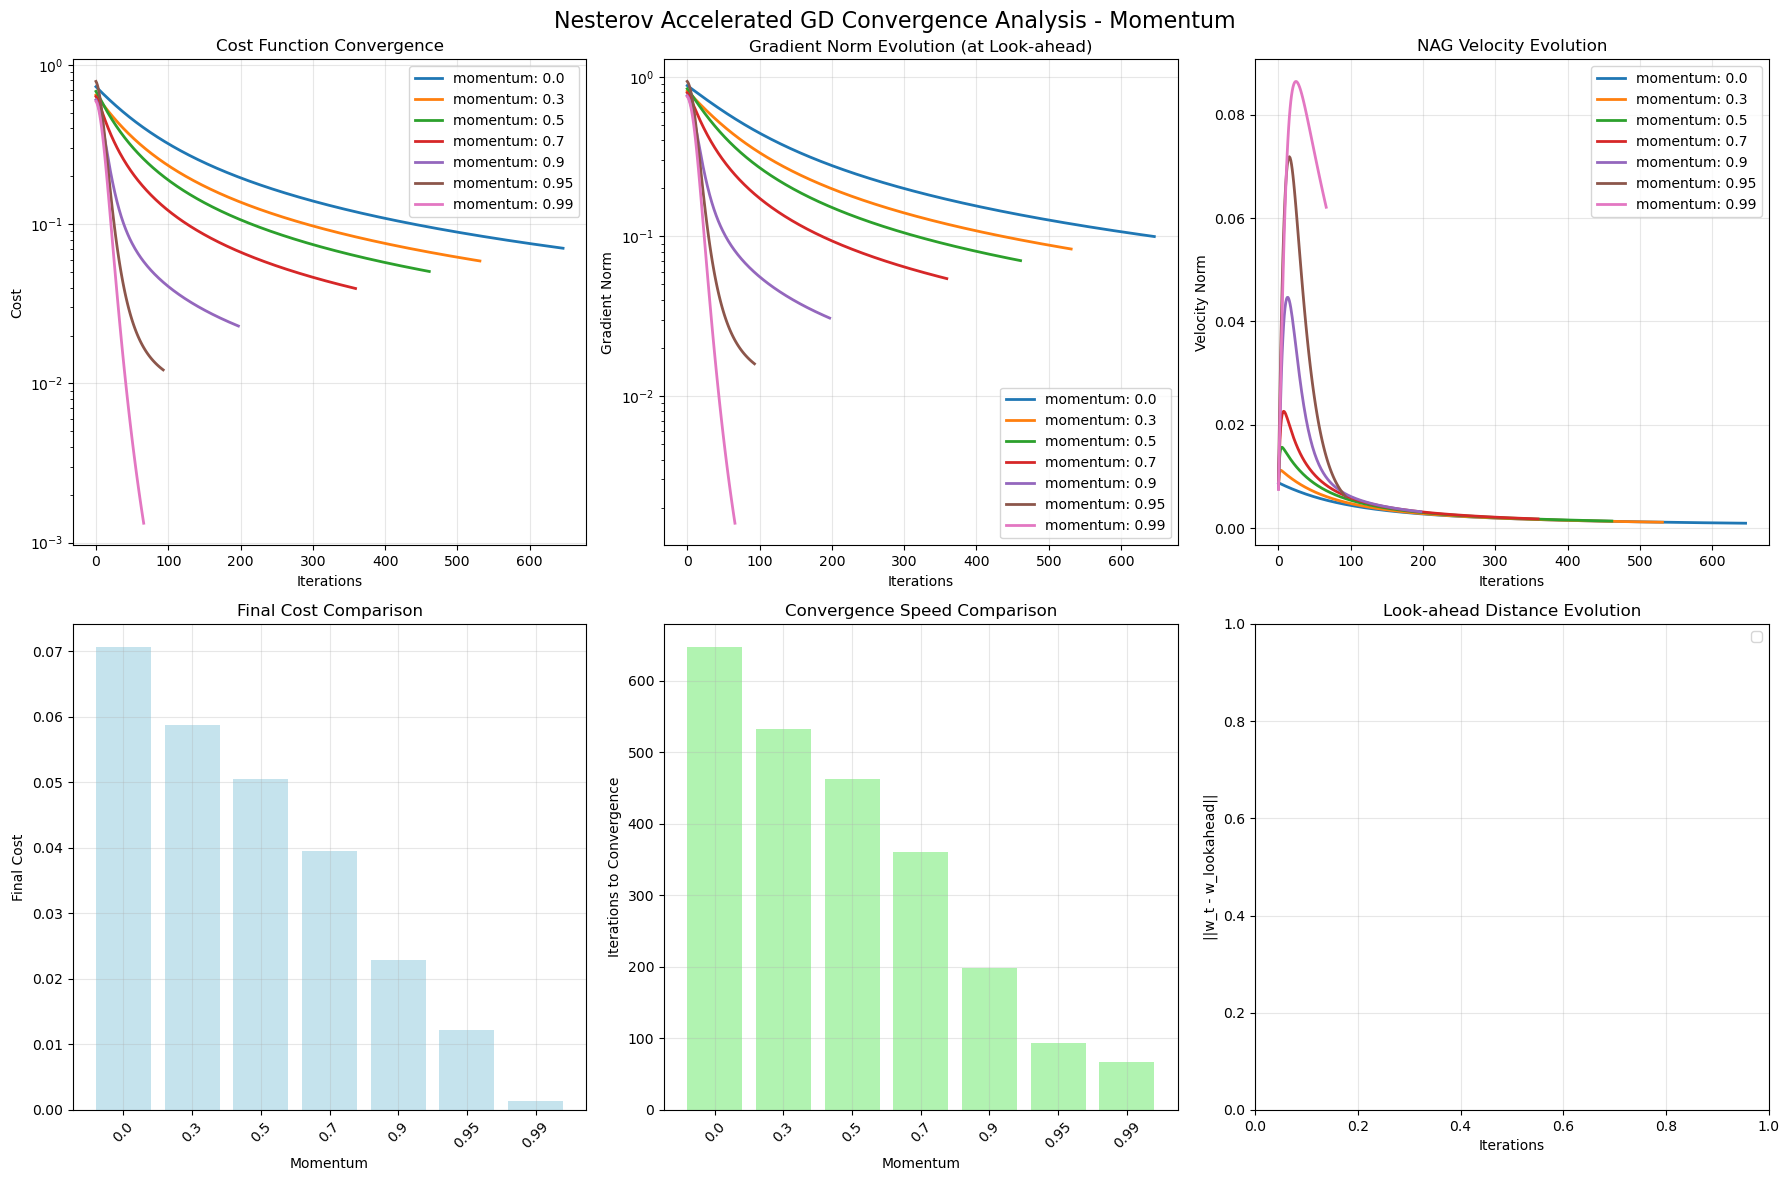

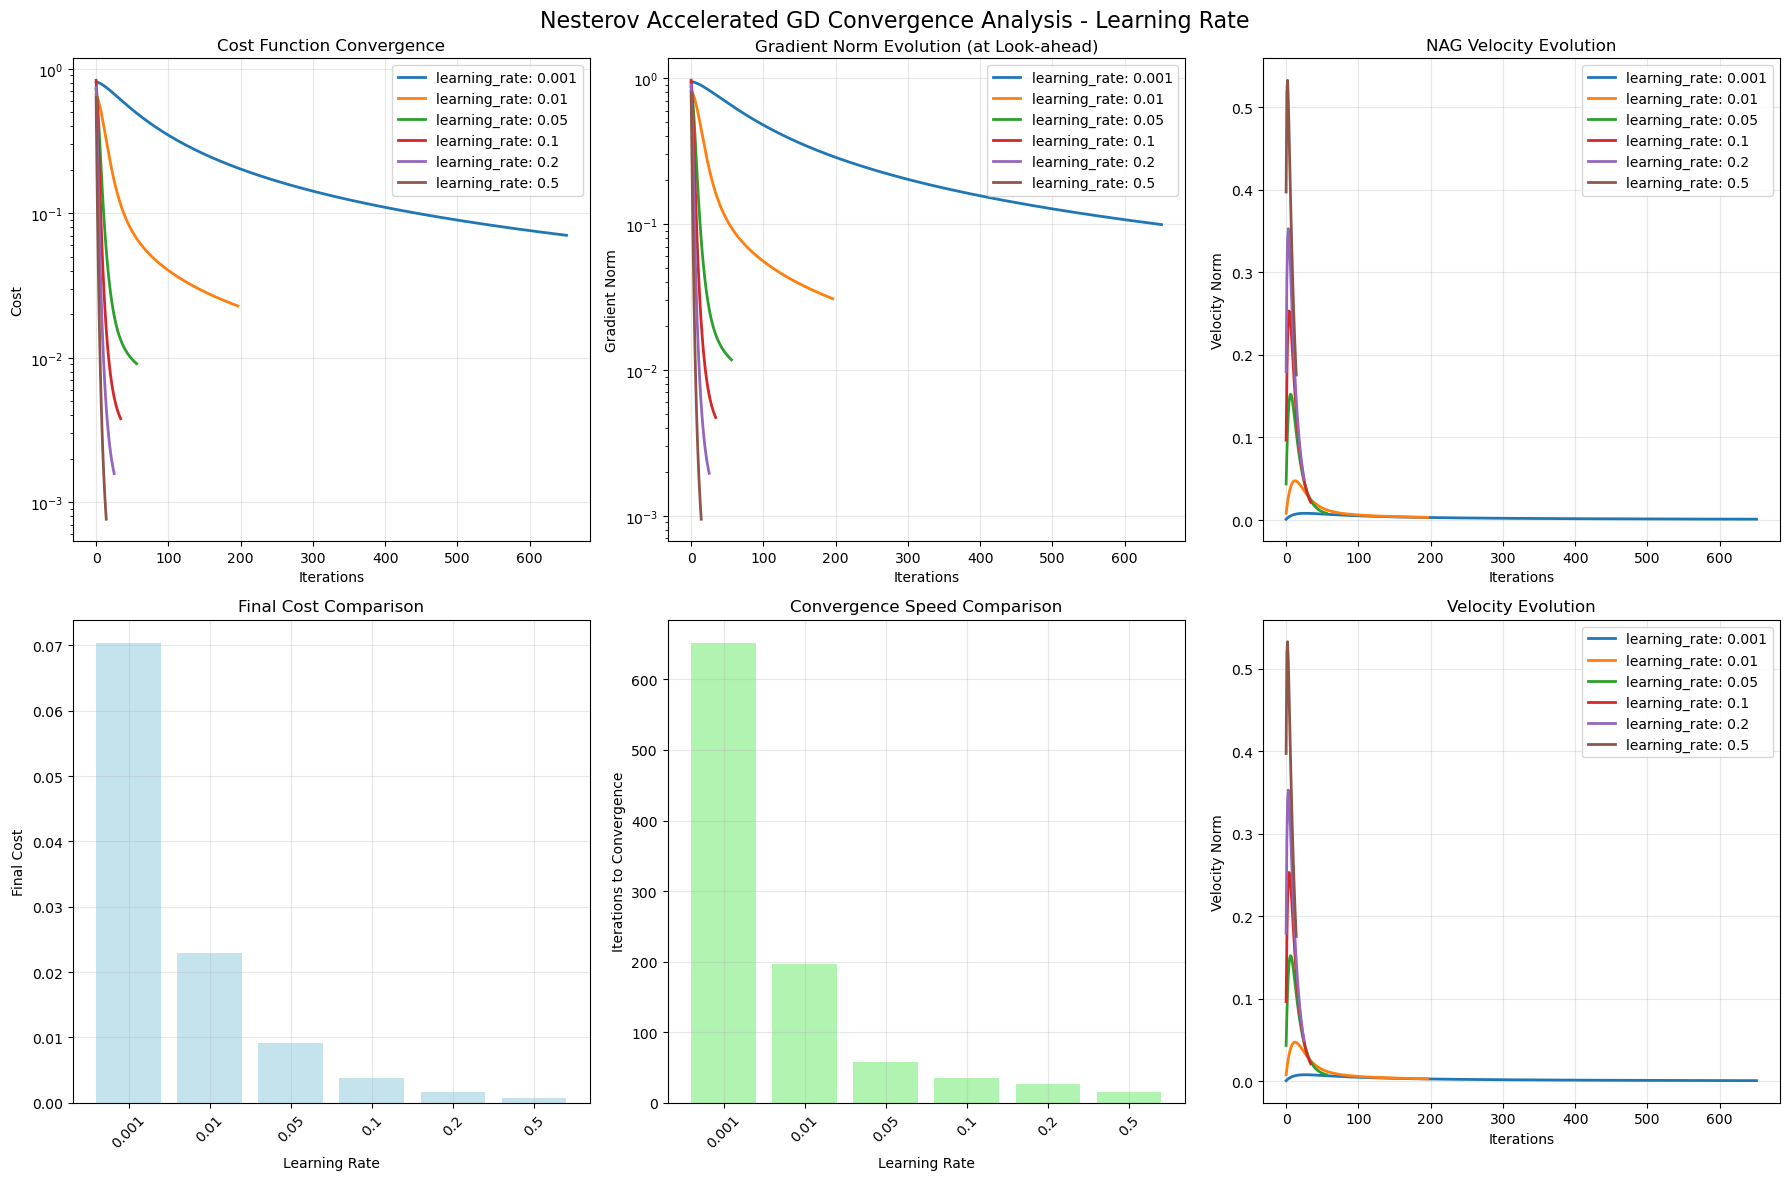

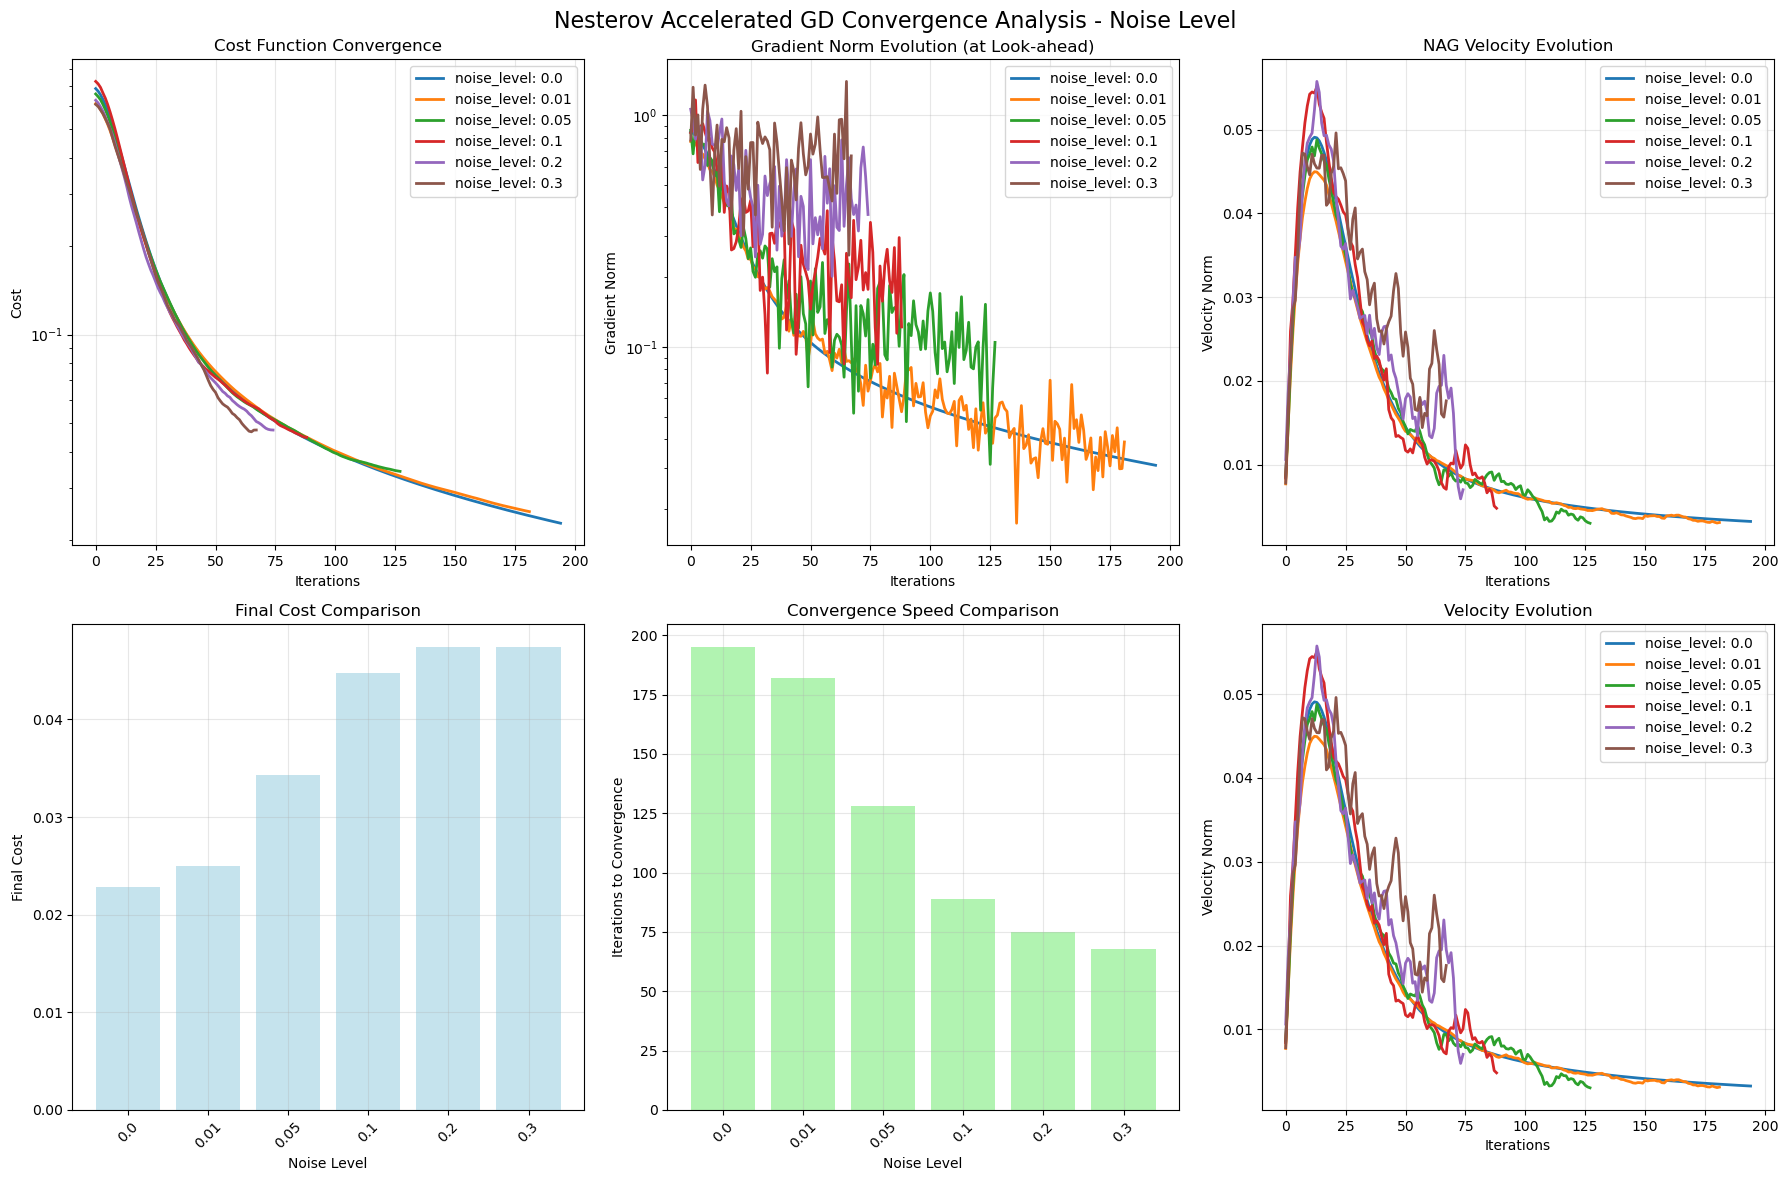

Comparing NAG vs Momentum GD vs Vanilla GD...


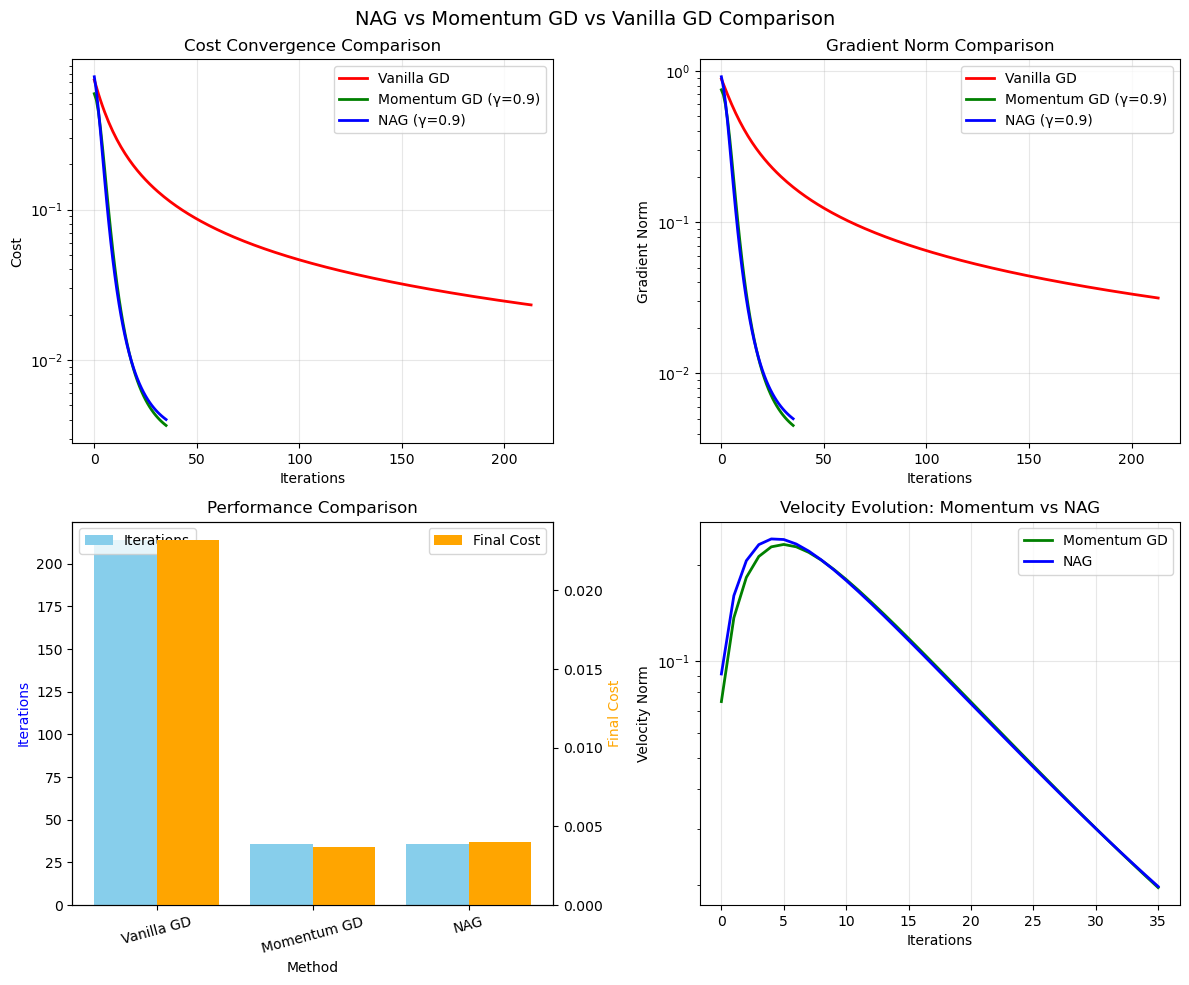

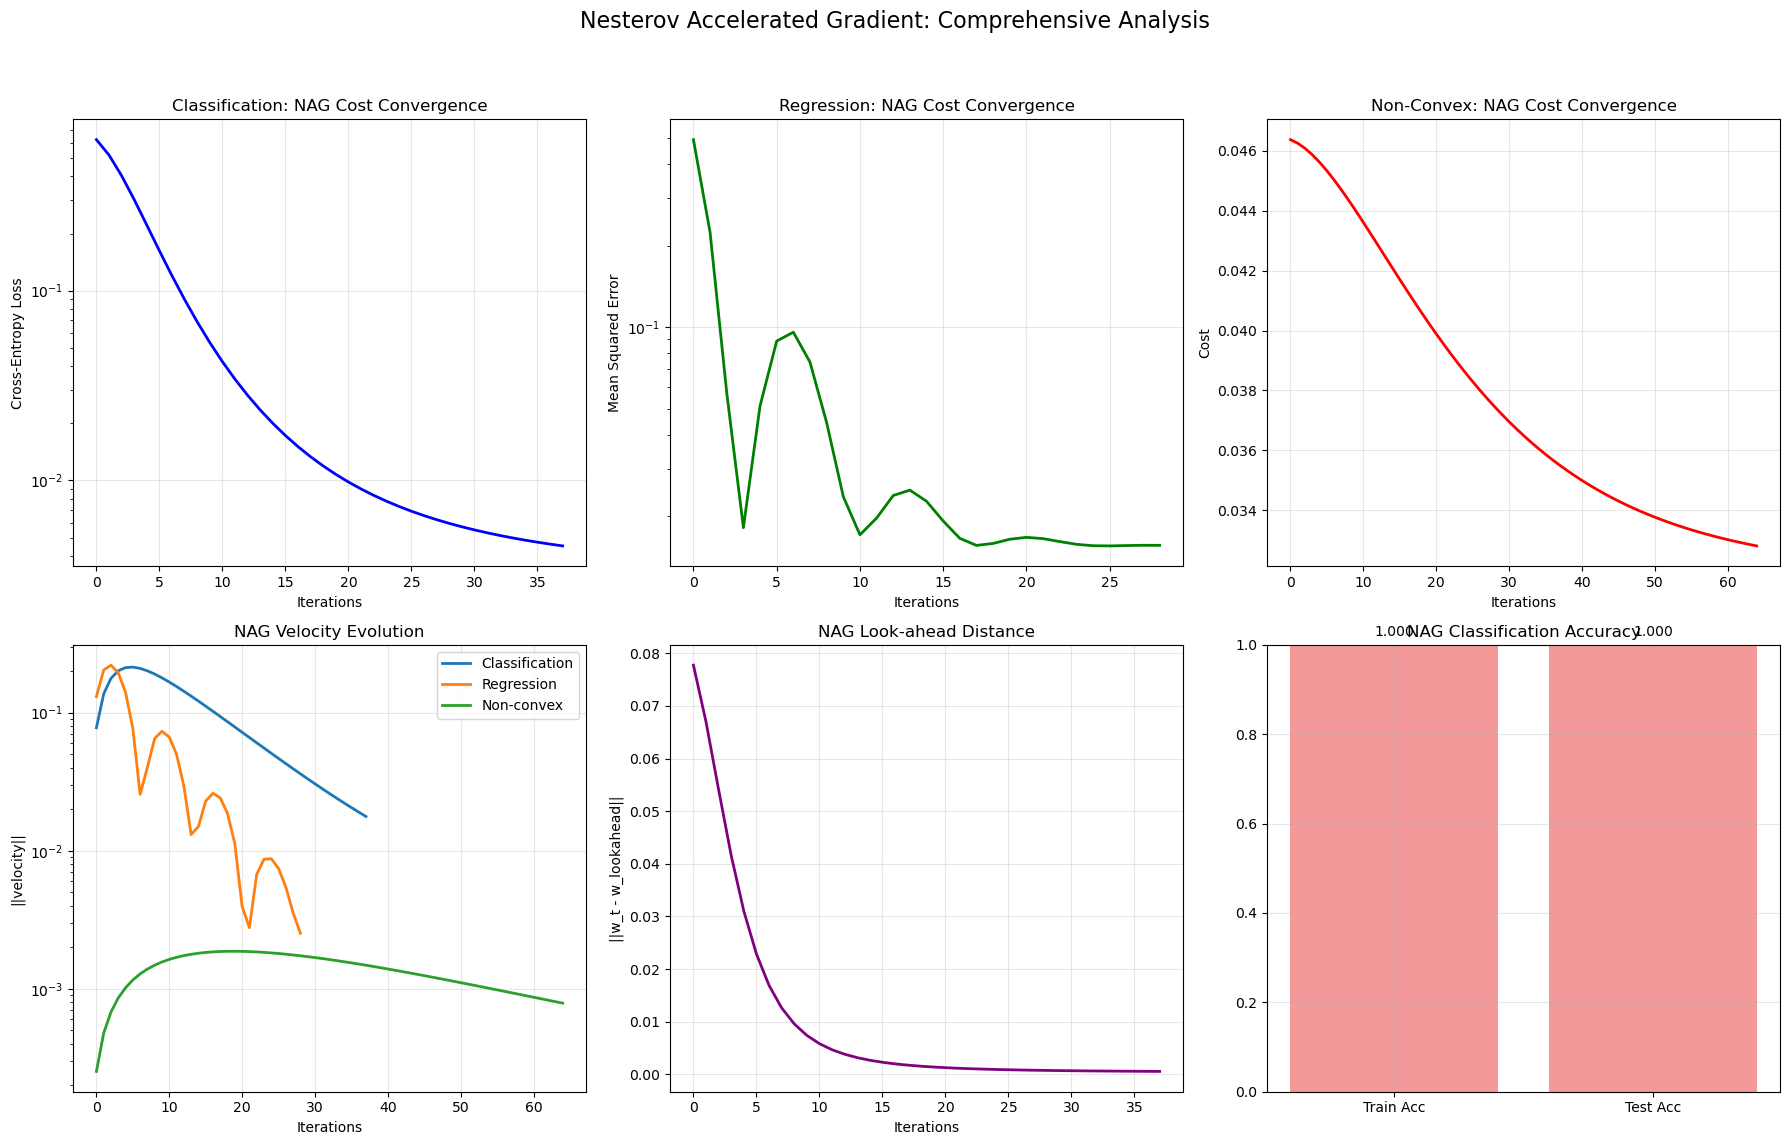


=== DETAILED NAG vs MOMENTUM COMPARISON ===


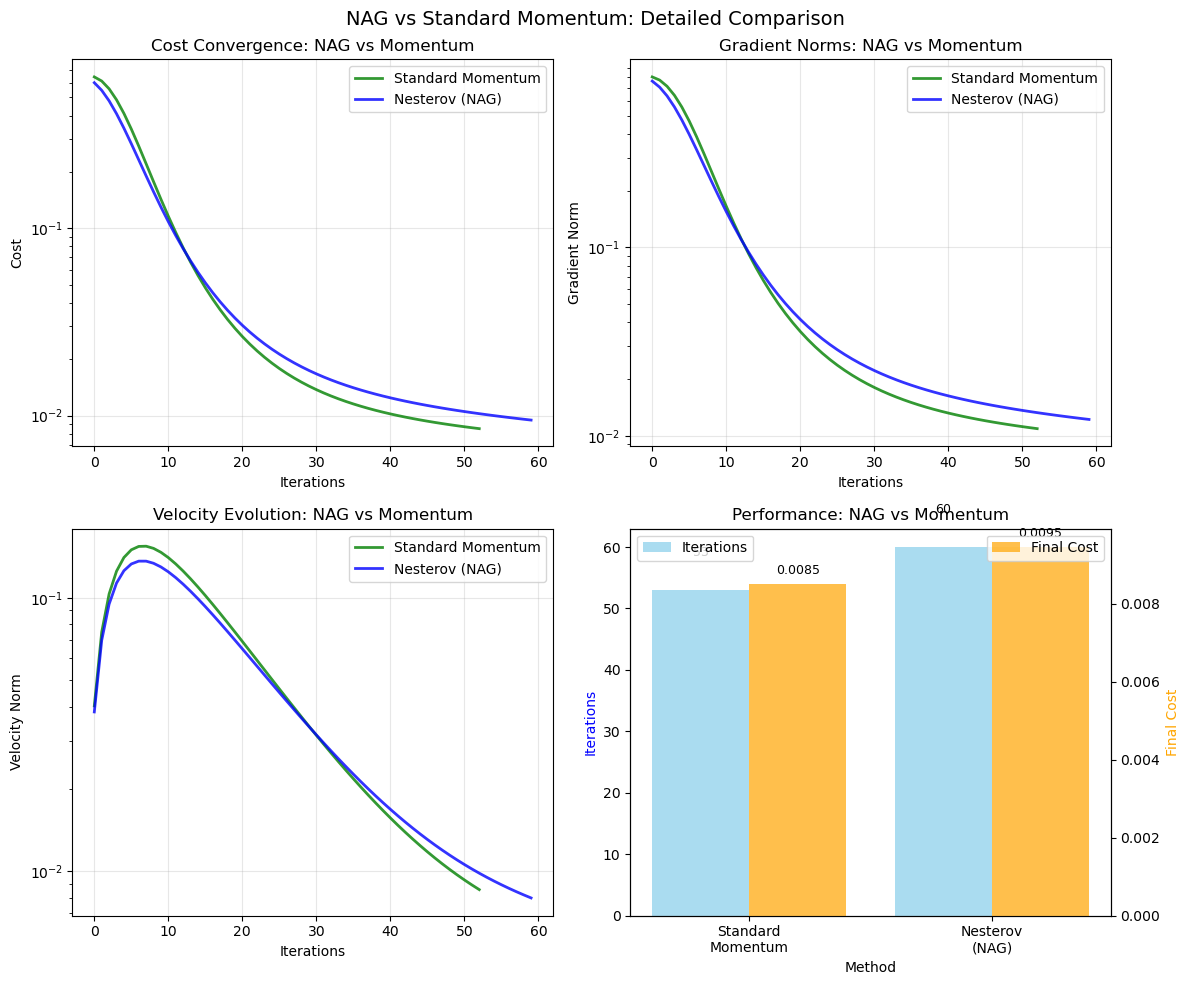


=== NAG SUMMARY ===
Classification:
  - Train Accuracy: 1.0000, Test Accuracy: 1.0000
  - Converged: True, Iterations: 38
Regression:
  - Train MSE: 0.031163, Test MSE: 0.034481
  - Converged: True, Iterations: 29
Non-Convex:
  - Final Cost: 0.032813
  - Converged: True, Iterations: 65

=== NAG vs MOMENTUM COMPARISON ===
NAG converged in 60 iterations
Standard Momentum converged in 53 iterations
NAG final cost: 0.009456
Momentum final cost: 0.008509
NAG speedup factor: 0.88x

=== NAG THEORETICAL ADVANTAGE DEMONSTRATION ===
Quadratic function condition number: 178.46
Testing lr=0.01, momentum=0.9
Testing lr=0.01, momentum=0.95
Testing lr=0.01, momentum=0.99
Testing lr=0.05, momentum=0.9
Testing lr=0.05, momentum=0.95
Testing lr=0.05, momentum=0.99
Testing lr=0.1, momentum=0.9
Testing lr=0.1, momentum=0.95
Testing lr=0.1, momentum=0.99


C:\Users\dhani\AppData\Local\Temp\ipykernel_17524\2219697592.py:22: RuntimeWarning: overflow encountered in matmul
  cost = 0.5 * weights.T @ A @ weights - b.T @ weights


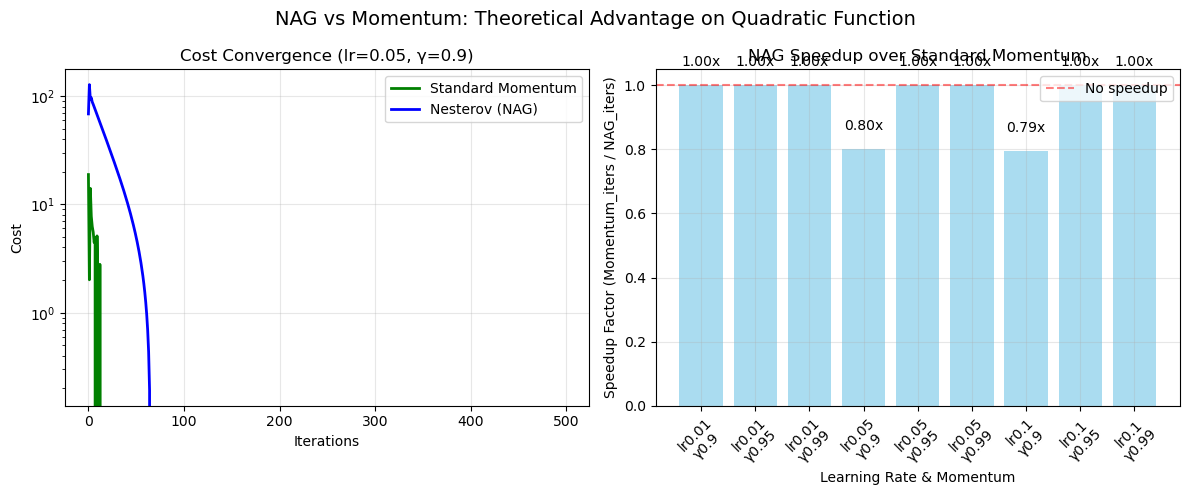


NESTEROV ACCELERATED GRADIENT ANALYSIS COMPLETE

Key Insights:
1. NAG computes gradients at 'look-ahead' positions
2. This often provides faster convergence than standard momentum
3. Most effective on strongly convex problems
4. Look-ahead mechanism helps avoid overshooting


In [14]:
if __name__ == "__main__":
    # Run the main NAG demonstration
    results = demonstrate_nesterov_accelerated_gradient()    
    # Run theoretical comparison
    theory_results = compare_nag_convergence_theory()
    
    print("\n" + "="*60)
    print("NESTEROV ACCELERATED GRADIENT ANALYSIS COMPLETE")
    print("="*60)
    print("\nKey Insights:")
    print("1. NAG computes gradients at 'look-ahead' positions")
    print("2. This often provides faster convergence than standard momentum")
    print("3. Most effective on strongly convex problems")
    print("4. Look-ahead mechanism helps avoid overshooting")